<a href="https://colab.research.google.com/github/shrishankar-desai/2024-FLAME-AI-Challenge/blob/main/data_project_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# FLAME AI Challenge

## Importing .dat file

In [ ]:
import numpy as np
import pandas as pd

In [ ]:
#importing all the data set.

fire_train_metadata = pd.read_csv('2024-flame-ai-challenge/dataset/train.csv')
fire_test_metadata = pd.read_csv('2024-flame-ai-challenge/dataset/test.csv')
train_data= r'2024-flame-ai-challenge/dataset/train'
test_data=r'2024-flame-ai-challenge/dataset/test'

In [ ]:
fire_train_metadata.head()

,id,u,alpha,Nt,Nx,Ny,theta_filename,ustar_filename,xi_filename
0,804025,2,10,150,113,32,theta_K_id804025.dat,ustar_ms-1_id804025.dat,xi_id804025.dat
1,875935,2,5,150,113,32,theta_K_id875935.dat,ustar_ms-1_id875935.dat,xi_id875935.dat
2,930086,6,0,150,113,32,theta_K_id930086.dat,ustar_ms-1_id930086.dat,xi_id930086.dat
3,661713,4,5,150,113,32,theta_K_id661713.dat,ustar_ms-1_id661713.dat,xi_id661713.dat
4,633229,2,0,150,113,32,theta_K_id633229.dat,ustar_ms-1_id633229.dat,xi_id633229.dat


In [ ]:
import os
def fire_data_import(meta_data,data_path):

    x=[]
    for i,row in meta_data.iterrows():
        nt, Nx, Ny = row['Nt'], row['Nx'], row['Ny']
        theta = np.fromfile(os.path.join(data_path, row['theta_filename']), dtype="<f4").reshape(nt, Nx, Ny)
        ustar = np.fromfile(os.path.join(data_path, row['ustar_filename']), dtype="<f4").reshape(nt, Nx, Ny)
        xi_f = np.fromfile(os.path.join(data_path, row['xi_filename']), dtype="<f4").reshape(nt, Nx, Ny)

        # mentioning shape of metadata for column u and alpha
        u  = np.array(row['u'])
        alpha = np.array(row['alpha'])
        # transfering theta value for the shape like metadata
        u = np.full_like(theta,u)
        alpha = np.full_like(theta,alpha)
        #appending normalized values
        x.append(np.stack([xi_f,theta/1_000,u/50,alpha/50,ustar/50],axis=-1))
    return x


# Import train data

In [ ]:
train=fire_data_import(fire_train_metadata,train_data)
train = np.array(train)
print(train.shape)

(9, 150, 113, 32, 5)


In [ ]:
train=train.transpose(0, 1, 4, 2, 3)
train.shape

(9, 150, 5, 113, 32)

In [ ]:
length_of_datax=6
length_of_datay=20
train = np.pad(train, pad_width=((0, 0), (0, 0), (0, 0), (0, 3), (0, 0)), mode='edge')
y = train[:,length_of_datax:]
x = train[:,:-length_of_datax]

print(x.shape,y.shape)

(9, 144, 5, 116, 32) (9, 144, 5, 116, 32)


## creating 2 data flattened data frames for features and target

# Import actual test data

In [ ]:
test=fire_data_import(fire_test_metadata,test_data)
test = np.array(train)
print(test.shape)

(9, 150, 5, 116, 32)


In [ ]:
y_actual_test = test[:,length_of_datax:]
x_actual_test = test[:,:-length_of_datax]

print(x_actual_test.shape,y_actual_test.shape)

(9, 144, 5, 116, 32) (9, 144, 5, 116, 32)


# visualizing

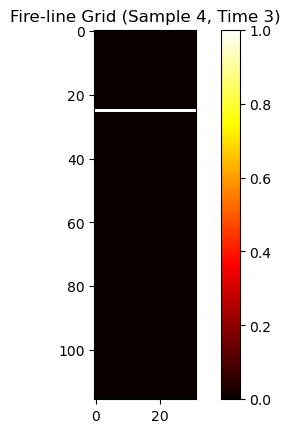

In [ ]:
import matplotlib.pyplot as plt

# Plot a sample grid for fire-line (xi_f)
sample_idx = 4  # Index of the simulation sample
time_idx = 3    # Time step to visualize

plt.imshow(x[sample_idx, time_idx, 0], cmap="hot")  # Fire-line is in channel 0
plt.colorbar()
plt.title("Fire-line Grid (Sample 4, Time 3)")
plt.show()

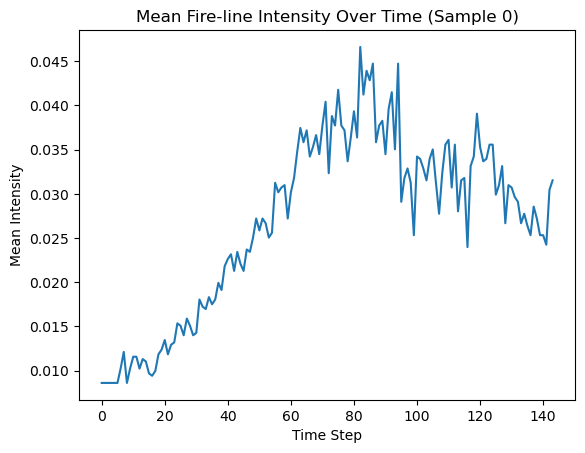

In [ ]:
# Plot mean values over time for fire-line in a single simulation
fire_line_values = x[sample_idx, :, 0].mean(axis=(1, 2))

plt.plot(fire_line_values)
plt.title("Mean Fire-line Intensity Over Time (Sample 0)")
plt.xlabel("Time Step")
plt.ylabel("Mean Intensity")
plt.show()

# preprocessing

In [ ]:
print("Missing values:", np.isnan(x).sum())
print("Infinite values:", np.isinf(x).sum())

Missing values: 0
Infinite values: 0


In [ ]:
print(x.shape)
print(y.shape)
print(x_actual_test.shape)
print(y_actual_test.shape)

(9, 144, 5, 116, 32)
(9, 144, 5, 116, 32)
(9, 144, 5, 116, 32)
(9, 144, 5, 116, 32)


# Splitting data

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Temporal slicing of train data

In [ ]:
import numpy as np

input_seq_length = 19
output_seq_length = 1
step = 1

def slice_dataset(data_x, data_y, input_seq_length, output_seq_length):
    x_slices = []
    y_slices = []

    # Iterate over simulations in the dataset
    for i in range(len(data_x)):
        # Slice each simulation into overlapping windows
        for j in range(len(data_x[i]) - input_seq_length - output_seq_length + 1):
            x_slices.append(data_x[i, j:j + input_seq_length])
            y_slices.append(data_y[i, j + input_seq_length:j + input_seq_length + output_seq_length])

    return np.array(x_slices), np.array(y_slices)


# Apply to training, validation, and test datasets
X_train_sliced, y_train_sliced = slice_dataset(X_train, y_train, input_seq_length, output_seq_length)
X_val_sliced, y_val_sliced = slice_dataset(X_test, y_test, input_seq_length, output_seq_length)


# Print shapes
print(f"Sliced X_train shape: {X_train_sliced.shape}")
print(f"Sliced y_train shape: {y_train_sliced.shape}")
print(f"Sliced X_val shape: {X_val_sliced.shape}")
print(f"Sliced y_val shape: {y_val_sliced.shape}")

Sliced X_train shape: (875, 19, 5, 116, 32)
Sliced y_train shape: (875, 1, 5, 116, 32)
Sliced X_val shape: (250, 19, 5, 116, 32)
Sliced y_val shape: (250, 1, 5, 116, 32)


# model implimenting

## CNN model

In [ ]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import (Conv3D, BatchNormalization, MaxPooling3D, Flatten, Dense, Dropout, Reshape)

height = 5
width = 116
features = 32
model = Sequential([
    Conv3D(32, kernel_size=(3, 1, 3), activation='relu', input_shape=(19, 5, 116, 32)),
    BatchNormalization(),
    MaxPooling3D(pool_size=(2, 1, 2)),
    Conv3D(64, kernel_size=(3, 1, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling3D(pool_size=(2, 1, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(aft_seq_length * height * width * features, activation='linear'),
    Reshape((aft_seq_length, height, width, features))
])


/Users/abhi/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d_2 (Conv3D)               │ (None, 17, 5, 114, 32) │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 17, 5, 114, 32) │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_2 (MaxPooling3D)  │ (None, 8, 5, 57, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_3 (Conv3D)               │ (None, 6, 5, 55, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 6, 5, 55, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_3 (MaxPooling3D)  │ (None, 3, 5, 27, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 25920)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │     3,317,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 18560)          │     2,394,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_3 (Reshape)             │ (None, 1, 5, 116, 32)  │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,740,256 (21.90 MB)

 Trainable params: 5,740,064 (21.90 MB)

 Non-trainable params: 192 (768.00 B)

In [ ]:
history = model.fit(
    X_train_sliced, y_train_sliced,
    validation_data=(X_val_sliced, y_val_sliced),
    epochs=50,
    batch_size=8,
    verbose=1
)

Epoch 1/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 16s 139ms/step - loss: 0.0301 - mae: 0.1176 - val_loss: 0.0176 - val_mae: 0.0897
Epoch 2/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 13s 118ms/step - loss: 0.0136 - mae: 0.0728 - val_loss: 0.0114 - val_mae: 0.0701
Epoch 3/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 13s 119ms/step - loss: 0.0094 - mae: 0.0571 - val_loss: 0.0093 - val_mae: 0.0596
Epoch 4/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 13s 117ms/step - loss: 0.0079 - mae: 0.0482 - val_loss: 0.0087 - val_mae: 0.0533
Epoch 5/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 13s 120ms/step - loss: 0.0074 - mae: 0.0426 - val_loss: 0.0086 - val_mae: 0.0509
Epoch 6/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 14s 125ms/step - loss: 0.0072 - mae: 0.0406 - val_loss: 0.0086 - val_mae: 0.0499
Epoch 7/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 14s 130ms/step - loss: 0.0073 - mae: 0.0402 - val_loss: 0.0085 - val_mae: 0.0496
Epoch 8/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 13s 117ms/step - loss: 0.0073 - mae: 0.0401 - val_loss: 0.0086 - val_mae: 0.0500
Epoch 9/50
110/110 ━━━━━━━━━━━━━

Test the Model

# Temporal slicing test data

In [ ]:
# Parameters based on training slice
input_seq_length = 19  # Match X_train input temporal size
output_seq_length = 1  # Match y_train output temporal size

x_test_slices = []
y_test_slices = []

# Slice the test data
for i in range(len(x_actual_test)):
    for j in range(len(x_actual_test[i]) - input_seq_length - output_seq_length + 1):
        x_test_slices.append(x_actual_test[i, j:j + input_seq_length])
        y_test_slices.append(y_actual_test[i, j + input_seq_length:j + input_seq_length + output_seq_length])

# Convert to numpy arrays
x_test_slices = np.array(x_test_slices)
y_test_slices = np.array(y_test_slices)

print(f"Sliced x_test shape: {x_test_slices.shape}")
print(f"Sliced y_test shape: {y_test_slices.shape}")


Sliced x_test shape: (1125, 19, 5, 116, 32)
Sliced y_test shape: (1125, 1, 5, 116, 32)


In [ ]:
test_loss, test_mae = model.evaluate(x_test_slices, y_test_slices, verbose=1)
print(f"Test Loss: {test_loss}, Test MAE: {test_mae}")



36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - loss: 0.0070 - mae: 0.0415
Test Loss: 0.0075372373685240746, Test MAE: 0.04219132289290428


Aggregate Results

In [ ]:
y_pred = model.predict(x_test_slices)

# Aggregate predictions to match the original `y_actual_test` shape
aggregated_predictions = np.zeros_like(y_actual_test)
counts = np.zeros_like(y_actual_test)

for i in range(len(x_actual_test)):
    for j in range(len(x_actual_test[i]) - input_seq_length - output_seq_length + 1):
        aggregated_predictions[i, j + input_seq_length:j + input_seq_length + output_seq_length] += y_pred[j]
        counts[i, j + input_seq_length:j + input_seq_length + output_seq_length] += 1

aggregated_predictions /= np.maximum(counts, 1)  # Avoid division by zero


36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step


Verify Predictions

In [ ]:
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(y_actual_test.flatten(), aggregated_predictions.flatten())
print(f"Aggregated MSE: {mse}")

Aggregated MSE: 0.010099014267325401


In [ ]:
from sklearn.metrics import r2_score

# Assuming aggregated_predictions contains the model's predictions for x_actual_test
# Flatten both arrays to ensure compatibility
y_test_flat = y_actual_test.flatten()
y_pred_flat = aggregated_predictions.flatten()

# Compute R-squared
r2 = r2_score(y_test_flat, y_pred_flat)
print(f"R-squared (R2): {r2}")

R-squared (R2): 0.35781101080356414


Evaluate and Visualize Results

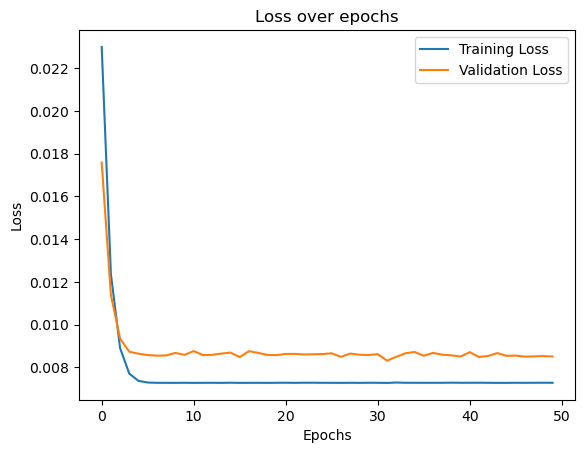

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss over epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()



## LSTM model

In [ ]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Reshape, Input

model_lstm = Sequential([
    Reshape((19, 5 * 116 * 32), input_shape=(19, 5, 116, 32)),
    LSTM(128, return_sequences=True),
    Dropout(0.5),
    LSTM(64, return_sequences=False),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(aft_seq_length * height * width * features, activation='linear'),
    Reshape((aft_seq_length, height, width, features))
])


model_lstm.summary()


/Users/abhi/anaconda3/lib/python3.11/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ reshape_4 (Reshape)             │ (None, 19, 18560)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 19, 128)        │     9,568,768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 19, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 18560)          │     2,394,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_5 (Reshape)             │ (None, 1, 5, 116, 32)  │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,020,736 (45.86 MB)

 Trainable params: 12,020,736 (45.86 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model_lstm.compile(optimizer='adam', loss='mse', metrics=['mae'])

In [ ]:
history = model_lstm.fit(
    X_train_sliced, y_train_sliced,
    validation_data=(X_val_sliced, y_val_sliced),
    epochs=50,
    batch_size=8,
    verbose=1
)

Epoch 1/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 17s 143ms/step - loss: 0.0144 - mae: 0.0746 - val_loss: 0.0075 - val_mae: 0.0459
Epoch 2/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 15s 135ms/step - loss: 0.0068 - mae: 0.0402 - val_loss: 0.0075 - val_mae: 0.0458
Epoch 3/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 15s 136ms/step - loss: 0.0062 - mae: 0.0352 - val_loss: 0.0079 - val_mae: 0.0472
Epoch 4/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 15s 137ms/step - loss: 0.0061 - mae: 0.0345 - val_loss: 0.0070 - val_mae: 0.0410
Epoch 5/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 15s 136ms/step - loss: 0.0058 - mae: 0.0317 - val_loss: 0.0065 - val_mae: 0.0329
Epoch 6/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 15s 135ms/step - loss: 0.0056 - mae: 0.0312 - val_loss: 0.0067 - val_mae: 0.0375
Epoch 7/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 15s 136ms/step - loss: 0.0054 - mae: 0.0303 - val_loss: 0.0066 - val_mae: 0.0374
Epoch 8/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 15s 136ms/step - loss: 0.0054 - mae: 0.0305 - val_loss: 0.0066 - val_mae: 0.0389
Epoch 9/50
110/110 ━━━━━━━━━━━━━

In [ ]:
test_loss_lstm, test_mae_lstm = model_lstm.evaluate(x_test_slices, y_test_slices, verbose=1)
print(f"Test Loss: {test_loss_lstm}, Test MAE: {test_mae_lstm}")

36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 72ms/step - loss: 0.0030 - mae: 0.0163
Test Loss: 0.003329978557303548, Test MAE: 0.017266826704144478


In [ ]:
y_pred = model_lstm.predict(x_test_slices)

# Aggregate predictions to match the original `y_actual_test` shape
aggregated_predictions = np.zeros_like(y_actual_test)
counts = np.zeros_like(y_actual_test)

for i in range(len(x_actual_test)):
    for j in range(len(x_actual_test[i]) - input_seq_length - output_seq_length + 1):
        aggregated_predictions[i, j + input_seq_length:j + input_seq_length + output_seq_length] += y_pred[j]
        counts[i, j + input_seq_length:j + input_seq_length + output_seq_length] += 1

aggregated_predictions /= np.maximum(counts, 1)

36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step


In [ ]:
mse = mean_squared_error(y_actual_test.flatten(), aggregated_predictions.flatten())
print(f"Aggregated MSE: {mse}")

Aggregated MSE: 0.012048082426190376


In [ ]:
y_test_flat = y_actual_test.flatten()
y_pred_flat = aggregated_predictions.flatten()

# Compute R-squared
r2 = r2_score(y_test_flat, y_pred_flat)
print(f"R-squared (R2): {r2}")

R-squared (R2): 0.23387058318729304


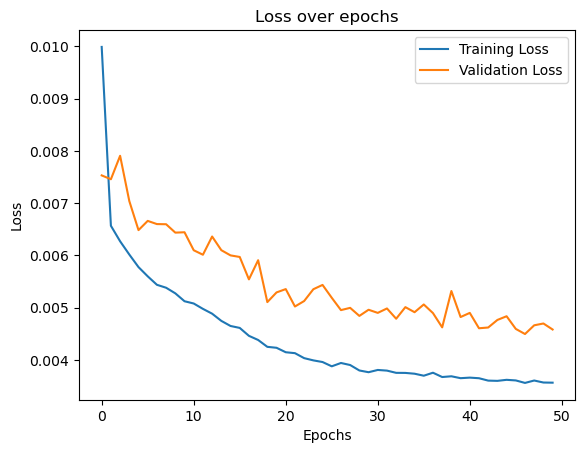

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss over epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

## R-squared (R2): 0.3587931990623474  for CNN model
## R-squared(R2): 0.21872717142105103 for LSTM model ,
## comparing both CNN is doing better.

## MSE: 0.010083557106554508 for CNN
## MSE: 0.012286222539842129 for LSTM model
## the CNN model has better predictive accuracy then LSTM model

# to save output prediction

In [ ]:
# Save the model in the native Keras format
model.save('flame_model.keras')

# Load the model
from tensorflow.keras.models import load_model
model = load_model('flame_model.keras')

/Users/abhi/anaconda3/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 14 variables whereas the saved optimizer has 26 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
